In [1]:
using Base: @kwdef
using Parameters: @unpack
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot
rc("axes.spines", top=false, right=false)
rc("font", family="Arial") 

In [2]:
@kwdef struct Reaching1DModelParameter
    n = 4 # number of dims
    p = 3 # 
    i = 0.25 # kgm^2, 
    b = 0.2 # kgm^2/s
    ta = 0.03 # s
    te = 0.04 # s
    L0 = 0.35 # m

    bu = 1 / (ta * te * i)
    α1 = bu * b
    α2 = 1/(ta * te) + (1/ta + 1/te) * b/i
    α3 = b/i + 1/ta + 1/te

    A = [zeros(p) I(p); -[0, α1, α2, α3]']
    B = [zeros(p); bu]
    C = [I(p) zeros(p)]
    D = Diagonal([1e-3, 1e-2, 5e-2])

    Y = 0.02 * B
    G = 0.03 * I(n)
end

@kwdef struct Reaching1DModelCostParameter
    n = 4
    dt = 1e-2 # sec
    T = 0.5 # sec
    nt = round(Int, T/dt) # num time steps
    Q = [zeros(nt-1, n, n); reshape(Diagonal([1.0, 0.1, 1e-3, 1e-4]), (1, n, n))]
    R = 1e-4 / nt
    
    init_pos = -0.5
    x₁ = [init_pos; zeros(n-1)]#zeros(n)
    Σ₁ = zeros(n, n)
end

Reaching1DModelCostParameter

In [3]:
function LQG(param::Reaching1DModelParameter, cost_param::Reaching1DModelCostParameter)
    @unpack n, p, A, B, C, D, G = param
    @unpack Q, R, x₁, Σ₁, dt, nt = cost_param

    A = I + A * dt
    B = B * dt
    C = C * dt
    D = sqrt(dt) * D
    G = sqrt(dt) * G
    
    L = zeros(nt-1, n) # Feedback gains
    K = zeros(nt-1, n, p) # Kalman gains
    S = copy(Q[end, :, :]) # S_T = Q
    Σ = copy(Σ₁);

    for t in 1:nt-1
        K[t, :, :] = A * Σ * C' / (C * Σ * C' + D) # update K
        Σ = G + (A - K[t, :, :] * C) * Σ * A'      # update Σ
    end　

    cost = 0
    for t in nt-1:-1:1
        cost += tr(S * G)
        L[t, :] = (R + B' * S * B) \ B' * S * A # update L
        S = Q[t, :, :] + A' * S * (A - B * L[t, :]')     # update S
    end
    
    # adjust cost
    cost += x₁' * S * x₁
    return L, K, cost
end

LQG (generic function with 1 method)

In [4]:
function gLQG(param::Reaching1DModelParameter, cost_param::Reaching1DModelCostParameter, maxiter=200, ϵ=1e-8)
    @unpack n, p, A, B, C, D, Y, G = param
    @unpack Q, R, x₁, Σ₁, dt, nt = cost_param

    A = I + A * dt
    B = B * dt
    C = C * dt
    D = sqrt(dt) * D
    G = sqrt(dt) * G
    Y = sqrt(dt) * Y
    
    L = zeros(nt-1, n) # Feedback gains
    K = zeros(nt-1, n, p) # Kalman gains
    
    cost = zeros(maxiter)
    for i in 1:maxiter
        Sˣ = copy(Q[end, :, :])
        Sᵉ = zeros(n, n)
        Σˣ̂ = x₁ * x₁' # \Sigma TAB \^x TAB \hat TAB
        Σᵉ = copy(Σ₁)
        
        for t in 1:nt-1
            K[t, :, :] = A * Σᵉ * C' / (C * Σᵉ * C' + D)

            AmBL = A - B * L[t, :]'
            LΣˣ̂L = L[t, :]' * Σˣ̂ * L[t, :]

            Σˣ̂ = K[t, :, :] * C * Σᵉ * A' + AmBL * Σˣ̂ * AmBL'
            Σᵉ = G + (A - K[t, :, :] * C) * Σᵉ * A' + Y * LΣˣ̂L * Y'
        end
        
        for t in nt-1:-1:1
            cost[i] += tr(Sˣ * G + Sᵉ * (G + K[t, :, :] * D * K[t, :, :]'))
            
            L[t, :] = (R + B' * Sˣ * B + Y' * (Sˣ + Sᵉ) * Y) \ B' * Sˣ * A

            AmKC = A - K[t, :, :] * C
            Sᵉ = A' * Sˣ * B * L[t, :]' + AmKC' * Sᵉ * AmKC
            Sˣ = Q[t, :, :] + A' * Sˣ * (A - B * L[t, :]')
        end
        
        # adjust cost
        cost[i] += x₁' * Sˣ * x₁ + tr((Sˣ + Sᵉ) * Σ₁)
        if i > 1 && abs(cost[i] - cost[i-1]) < ϵ
            cost = cost[1:i]
            break
        end
    end
    return L, K, cost
end

gLQG (generic function with 3 methods)

In [5]:
function simulation(param::Reaching1DModelParameter, cost_param::Reaching1DModelCostParameter, 
                    L, K; noisy=false)
    @unpack n, p, A, B, C, D, Y, G = param
    @unpack Q, R, x₁, dt, nt = cost_param
    
    X = zeros(n, nt)
    u = zeros(nt)
    X[:, 1] = x₁ # m; initial position (target position is zero)

    if noisy
        sqrtdt = √dt
        X̂ = zeros(n, nt)
        X̂[1, 1] = X[1, 1]
        for t in 1:nt-1
            u[t] = -L[t, :]' * X̂[:, t]
            X[:, t+1] = X[:,t] + (A * X[:,t] + B * u[t]) * dt + sqrtdt * (Y * u[t] * randn() + G * randn(n))
            dy = C * X[:,t] * dt + D * sqrtdt * randn(n-1)
            X̂[:, t+1] = X̂[:,t] + (A * X̂[:,t] + B * u[t]) * dt + K[t, :, :] * (dy - C * X̂[:,t] * dt)
        end
    else
        for t in 1:nt-1
            u[t] = -L[t, :]' * X[:, t]
            X[:, t+1] = X[:, t] + (A * X[:, t] + B * u[t]) * dt
        end
    end
    return X, u
end

simulation (generic function with 1 method)

In [6]:
function simulation_all(param, cost_param, L, K)
    Xa, ua = simulation(param, cost_param, L, K, noisy=false);
    
    # noisy
    nsim = 10
    XSimAll = []
    uSimAll = []
    for i in 1:nsim
        XSim, u = simulation(param, cost_param, L, K, noisy=true);
        push!(XSimAll, XSim)
        push!(uSimAll, u)
    end
    
    # visualization
    @unpack dt, T = cost_param
    tarray = collect(dt:dt:T)
    label = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]

    fig, ax = subplots(1, 3, figsize=(10, 3))
    for i in 1:2
        for j in 1:nsim
            ax[i].plot(tarray, XSimAll[j][i,:]', "tab:gray", alpha=0.5)
        end

        ax[i].plot(tarray, Xa[i,:], "tab:red")
        ax[i].set_ylabel(label[i]); ax[i].set_xlabel(L"Time ($s$)"); 
        ax[i].set_xlim(0, T); ax[i].grid()
    end

    for j in 1:nsim
        ax[3].plot(tarray, uSimAll[j], "tab:gray", alpha=0.5)
    end
    ax[3].plot(tarray, ua, "tab:red")
    ax[3].set_ylabel(L"Control signal ($N\cdot m$)"); ax[3].set_xlabel(L"Time ($s$)"); 
    ax[3].set_xlim(0, T); ax[3].grid()

    tight_layout()
end

simulation_all (generic function with 1 method)

In [7]:
param = Reaching1DModelParameter()
cost_param = Reaching1DModelCostParameter();

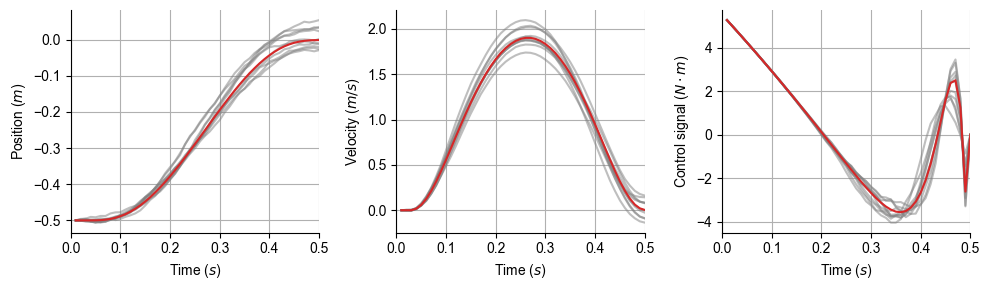

In [8]:
L, K, cost = LQG(param, cost_param);
simulation_all(param, cost_param, L, K)

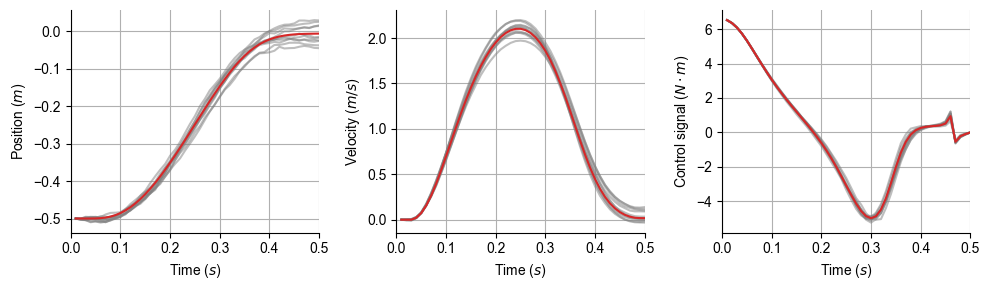

In [9]:
L, K, cost = gLQG(param, cost_param);
simulation_all(param, cost_param, L, K)